# Generating images using Stable Diffusion

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

이 데모 노트북에서는 [Amazon Bedrock](https://aws.amazon.com/bedrock/)에서 [Stable Diffusion XL](https://stability.ai/stablediffusion)(SDXL)을 이미지에 사용하는 방법을 보여줍니다. 생성(텍스트-이미지) 및 이미지 편집(이미지-이미지).



# 1. 설정

이 노트북의 나머지 부분을 실행하기 전에 아래 셀을 실행하여 (필요한 라이브러리가 설치되어 있는지 확인하고) Bedrock에 연결해야 합니다.

설정 작동 방식 및 ⚠️ **변경이 필요한지 여부**에 대한 자세한 내용은 [Bedrock boto3 설정 노트북](../00_Intro/bedrock_boto3_setup.ipynb) 노트북을 참조하세요.

이 노트북에서는 이미지 작업을 위해 [pillow](https://pillow.readthedocs.io/en/stable/)도 설치해야 합니다.

In [2]:
install_needed = True  # should only be True once
# install_needed = False  # should only be True once

In [3]:
# Make sure you ran `download-dependencies.sh` from the root of the repository first!
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U pip --quiet
    !{sys.executable} -m pip install -U sagemaker  --quiet  
    !{sys.executable} -m pip install "pillow>=9.5,<10" --quiet
    
    # IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.2.2 which is incompatible.


In [4]:
# Python Built-Ins:
import base64
import io
import json
import os
import sys

# External Dependencies:
import boto3
from PIL import Image

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
# os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


In [17]:
%load_ext autoreload
%autoreload 2

import sys, os
module_path = ".."
sys.path.append(os.path.abspath(module_path))

In [18]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
# os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print(colored("\n== FM lists ==", "green"))
pprint(bedrock_info.get_list_fm_models())

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Command': 'cohere.command-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'TBD'}


# 2. Text to Image

텍스트-이미지 모드에서는 `프롬프트`라고 불리는 **생성되어야 하는** 이미지에 대한 텍스트 설명을 제공합니다.

Stable Diffusion XL(SDXL)을 사용하면 특정 [스타일 사전 설정](https://platform.stability.ai/docs/release-notes#style-presets)을 지정하여 세대에 영향을 줄 수도 있습니다.

하지만 모델이 특정 콘텐츠나 스타일 선택을 ***피***하도록 유도하려면 어떻게 해야 할까요? 이미지 생성 모델은 일반적으로 *이미지 설명*을 통해 훈련되기 때문에 프롬프트에서 원하지 않는 것(예: `수염 없는 남자`)을 직접 지정하려고 시도하는 것은 일반적으로 잘 작동하지 않습니다. 이미지가 아닌 것으로 이미지를 설명하는 것은 매우 이례적입니다!

- 대신 SDXL을 사용하면 각 프롬프트에 대해 음수가 될 수 있는 '가중치'를 지정할 수 있습니다. 이를 사용하여 아래와 같이 `negative_prompts`를 제공합니다.

## 파라미터 
- 참조 링크
    - [The Most Complete Guide to Stable Diffusion Parameters](https://blog.openart.ai/2023/02/13/the-most-complete-guide-to-stable-diffusion-parameters/)
    - [style_preset 옵션을 탐색](https://platform.stability.ai/docs/features/animation/parameters#available-styles)
- CFG (다른 이름으로 Guidence Sacle 혹은 Prompt Guidance 로도 기술 됩니다.)
    - 기본적으로 생성된 이미지가 사용자의 프롬프트 또는 입력 이미지를 얼마나 밀접하게 준수하는지를 제어합니다.원본 프롬프트 및 입력 이미지 대한 출력 충실도와 출력 품질 사이의 균형을 조정할 수 있습니다.<font color="red"><b>CFG 배율 값이 높을수록 출력 이미지가 입력 프롬프트 또는 이미지와 더 일치하지만 품질이 저하됩니다. 반대로, CFG 배율 값이 낮을수록 원래 프롬프트나 이미지와 다를 수 있는 더 나은 품질의 이미지가 생성됩니다.</b></font>
        - CFG 2 – 6: Creative, but might be too distorted and not follow the prompt. Can be fun and useful for short prompts
        - CFG 7 – 10: Recommended for most prompts. Good balance between creativity and guided generation
        - CFG 10 – 15: When you’re sure that your prompt is detailed and very clear on what you want the image to look like
        - CFG 16 – 20: Not generally recommended unless the prompt is well-detailed. Might affect coherence and quality
        - CFG >20: almost never usable    
            - 상세보기: [cfg_scale](https://ambcrypto.com/blog/what-is-cfg-scale-in-stable-diffusion-and-what-does-it-do/)
            - 
- Start_Schedule
    - 확산 단계의 시작 부분을 건너뛰어 init_image가 최종 생성된 이미지에 영향을 미칠 수 있도록 합니다. 값이 낮을수록 init_image에서 더 많은 영향을 받고, 값이 높을수록 확산 단계에서 더 많은 영향을 받습니다. (예를 들어 값이 0이면 단순히 init_image가 반환되고, 값이 1이면 완전히 다른 이미지가 반환됩니다. 이 파라미터는 다른 파라미터와 같이 영향을 주므로, 반드시 이 값에 의한 효과가 100% 나오는 것은 아닙니다.)
    - 상세보기: [Start Schedule](https://platform.stability.ai/docs/features/api-parameters)

In [5]:
prompt = "Dog in a forest"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn dog",
    "disfigured dog features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
#prompt = "photo taken from above of an italian landscape. cloud is clear with few clouds. Green hills and few villages, a lake"

Amazon Bedrock `InvokeModel`은 올바른 모델 ID를 설정하여 SDXL에 대한 액세스를 제공하고 (PNG)를 나타내는 영상 [Base64 인코딩 문자열](https://en.wikipedia.org/wiki/Base64)을 포함하는 JSON 응답을 반환합니다.

모델에 사용 가능한 입력 매개변수에 대한 자세한 내용은 [Stability AI 문서](https://platform.stability.ai/docs/api-reference#tag/v1 Generation/Operation/textToImage)를 참조하세요.

아래 셀은 Amazon Bedrock을 통해 SDXL 모델을 호출하여 초기 이미지 문자열을 생성합니다.

In [6]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 5450,
    "steps": 70,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAEDGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


Base64 문자열을 바이너리로 디코딩하고 PNG 파일을 읽을 수 있는 [Pillow](https://pillow.readthedocs.io/en/stable/)와 같은 이미지 처리 라이브러리로 로드하면 여기에서 이미지를 표시하고 조작할 수 있습니다. 노트북에서:

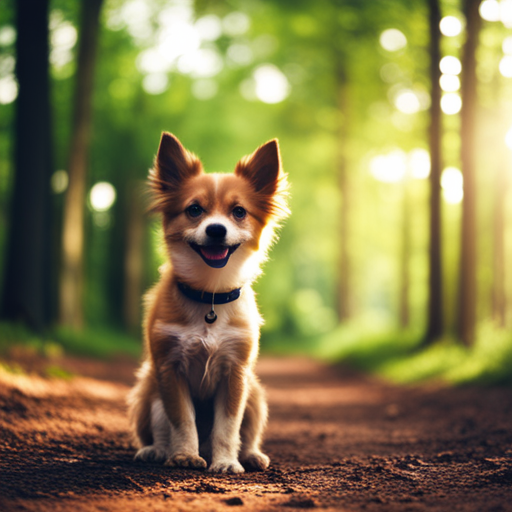

In [7]:
os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("data/image_1.png")
image_1

# 3. Image to Image

텍스트에서 이미지를 생성하는 것은 강력하지만 어떤 경우에는 "올바른" 이미지를 얻기 위해 즉각적인 개선 작업이 여러 차례 필요할 수 있습니다.

매번 텍스트로 처음부터 시작하는 대신 이미지 대 이미지 생성을 통해 **기존 이미지를 수정**하여 원하는 특정 변경 사항을 적용할 수 있습니다.

초기 이미지를 base64 인코딩으로 API에 전달해야 하므로 먼저 준비하겠습니다. 원하는 경우 이전 섹션의 초기 이미지를 사용하거나 다른 이미지를 사용할 수 있습니다.

In [8]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(image_1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nIz923YlSZIliO0tomp2DuCX...


그러면 모델이 초기 이미지에 따라 작동하도록 도울 수 있습니다.

In [9]:
change_prompt = "add some leaves around the dog"

그런 다음 기존 이미지는 'init_image' 매개변수를 통해 Stable Diffusion 모델로 전달됩니다.

다시 한번 말씀드리지만, 다양한 매개변수를 사용하는 방법에 대한 추가 팁은 [Stable Diffusion API 문서](https://platform.stability.ai/docs/api-reference#tag/v1Generation/Operation/imageToImage)를 참조하실 수 있습니다.



In [10]:
request = json.dumps({
    "text_prompts": (
        [{"text": change_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 321,
    "start_schedule": 0.6,
    "steps": 50,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAACkqGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


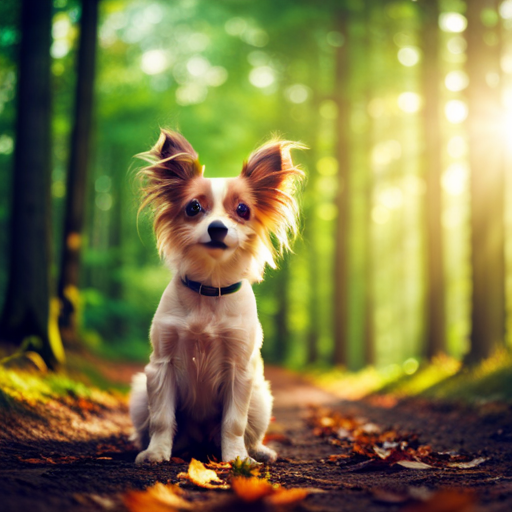

In [11]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2.save("data/image_2.png")
image_2

# 4. 옵션: Text-To-Image
옵션 파트는 Text-To-Image 의 코드를 함수로 만들어서 쉽게 호출하여 여러번 실험을 가능하게 한 것 입니다. 원 코드의 핵심 부분은 변경이 없습니다.
- 아래 출력 이미지는 data 폴더에 저장이 됩니다. 이 이미지를 로컬에 다운로드 받아서 사용할 수 있습니다.
- 아래 prompt, negative_prompts, cfg_scale 등의 다른 파라미터 값을 조정하면서 실험 해보세요.

In [12]:
import json

def generate_text_to_image(boto3_bedrock, prompt, negative_prompts, cfg_scale, seed, steps, style_preset, result_img_name):
    request = json.dumps({
        "text_prompts": (
            [{"text": prompt, "weight": 1.0}]
            + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
        ),
        "cfg_scale": cfg_scale,
        "seed": seed,
        "steps": steps,
        "style_preset": style_preset,
    })
    modelId = "stability.stable-diffusion-xl"

    response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())

    base_64_img_str = response_body["artifacts"][0].get("base64")
    

    image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
    image_1.save(f"data/{result_img_name}")
    
    return image_1    

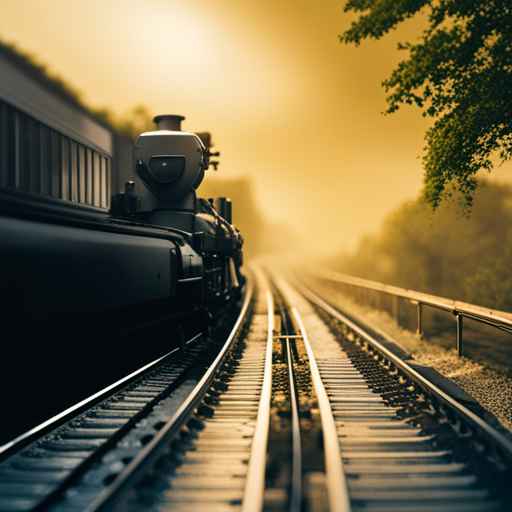

In [13]:
prompt = "A cybernatic locomotive on rainy day from the parallel universe"
negative_prompts = [
    "Bad quality",
    "bad detail",
    "blurry-image",
    "bad contrast",
    "bad anatomy",
    "duplicate",
    "watermark",
    "extra detail",
    "chaotic distribution of objects",
    "distortion",
    "bad detail facial details",
    
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
#prompt = "photo taken from above of an italian landscape. cloud is clear with few clouds. Green hills and few villages, a lake"


text2image = generate_text_to_image(
                       boto3_bedrock = boto3_bedrock,
                       prompt=prompt, 
                       negative_prompts=negative_prompts, 
                       cfg_scale=5, 
                       seed=5450, 
                       steps=70, 
                       style_preset=style_preset,
                       result_img_name="image_3.png"
                      )
text2image

# 5. 옵션: Image-To-Image
위의 옵션과 동일한 목적으로 함수를 마들었고, 아래 내용 수정해가면서 실험 해보세요.
- 아래 출력 이미지는 data 폴더에 저장이 됩니다. 이 이미지를 로컬에 다운로드 받아서 사용할 수 있습니다.
- 아래 change_prompt, negative_prompts, cft_scale 다른 파라미터 값을 조정하면서 실험 해보세요.

In [14]:
def generate_image_to_image(boto3_bedrock, change_prompt, init_image_b64, negative_prompts, cfg_scale, seed, start_schedule, steps, style_preset, result_img_name):
    request = json.dumps({
        "text_prompts": (
            [{"text": change_prompt, "weight": 1.0}]
            + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
        ),
        "cfg_scale": cfg_scale,
        "init_image": init_image_b64,
        "seed": seed,
        "start_schedule": 0.6,
        "steps": 50,
        "style_preset": style_preset,
    })
    modelId = "stability.stable-diffusion-xl"

    response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())

    image_2_b64_str = response_body["artifacts"][0].get("base64")

    image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
    image_1.save(f"data/{result_img_name}")

    return image_1

In [15]:
init_image_b64 = image_to_base64(text2image)
change_prompt = "add some buildings around the train"

Converting PIL Image to base64 string


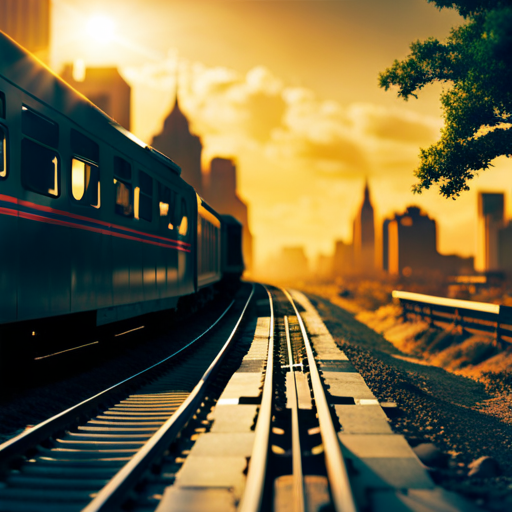

In [16]:
image_to_image = generate_image_to_image(
                       boto3_bedrock = boto3_bedrock,
                       change_prompt=change_prompt,
                       init_image_b64=init_image_b64, 
                       negative_prompts=negative_prompts, 
                       cfg_scale=10,
                       seed=321,
                       start_schedule=0.5,
                       steps=50,
                       style_preset=style_preset, 
                       result_img_name="image_4.png")
image_to_image

# 6. 요약

이 실습에서는 [Amazon Bedrock](https://aws.amazon.com/bedrock/) API를 통해 일반적으로 [Stable Diffusion API 문서](https://platform.stability.ai/docs/api-reference#tag/v1세대)에 나열된 매개변수에 해당하는 이미지 생성에 영향을 미치는 다양한 매개변수를 제공할 수 있습니다. ).

Bedrock을 사용할 때 주목해야 할 한 가지 핵심 사항은 출력 이미지 PNG/JPEG 데이터가 JSON API 응답 내에서 [Base64 인코딩 문자열](https://en.wikipedia.org/wiki/Base64)로 반환된다는 것입니다. Python에 내장된 [base64 라이브러리](https://docs.python.org/3/library/base64.html)는 이 이미지 데이터를 디코딩합니다(예: `.png` 파일 저장). 또한 [Pillow](https://pillow.readthedocs.io/en/stable/)와 같은 이미지 처리 라이브러리를 사용하여 Python 내에서 이미지를 로드(및 아마도 편집)할 수 있음을 보여주었습니다.

여기에서 고급 이미지 생성 옵션을 탐색하거나 GenAI를 기존 이미지 처리 도구와 결합하여 사용 사례에 가장 적합한 창의적인 워크플로를 구축할 수 있습니다.